![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/soilmechanics


In [1]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
import plot_functions.plot_settings

# Exercise 6 - Finite differences: soil column under gravity and top load

![soil_column.png](Images/soil_column.png)

## Governing differential equation

Consider the equilibrium conditions on an infinitesimal element of the soil column:

$$
    \uparrow: \quad F_z - \frac{\partial F_z}{\partial z}\text{d}z - F_z - \varrho g A \text{d}z = 0
$$

The vertical force is determined by $F_z = \sigma_{zz}A = E_\text{s} A \epsilon_{zz} = -E_\text{s} A u_{z,z}$. Therefore, the equilibrium conditions read:

$$
    0 = \left[ \frac{\partial}{\partial z} \left(E_\text{s} A \frac{\partial u_z}{\partial z}\right) - \varrho g A \right]\text{d}z
$$

Considering, that the equation has to hold for an arbitrary infinitesimal non-zero $\text{d}z$, we find the ordinary differential equation

$$
    0 = \frac{\partial}{\partial z} \left(E_\text{s} A \frac{\partial u_z}{\partial z}\right) - \varrho g A
$$

Nota bene: compare this to the differential equation for a rod ('Zugstab'): $(EAu')' + n = 0$. While the cross section of a rod can vary along its length, the cross-sectional area of a soil column is considered a constant, simplifying the equation further:

$$
    0 = \frac{\partial}{\partial z} \left(E_\text{s} \frac{\partial u_z}{\partial z}\right) - \varrho g
$$



Let's put this to test.

## Finite difference discretization

We assume $E_\text{s} = \text{const.}$ and arrive at

$$
    \frac{\partial^2 u_z}{\partial z^2} = \frac{\gamma}{E_\text{s}}
$$

In the finite difference method, we introduce a grid made up, in the one-dimensional case, of a series of points. The differentials are the evaluated by finite differences between values at these points:

$$
    \frac{\partial u_z}{\partial z} \approx \frac{\Delta u_z}{\Delta z} = \frac{u_i - u_{i-1}}{z_i - z_{i-1}} = u_i'
$$

where here, backward differences were chosen (viz. forward and central differences). We also assume a constant $\Delta z$ here.

A second derivative can likewise be approximated (now using forward differences):

$$
    \frac{\partial^2 u_z}{\partial z^2} \approx u_i'' = \frac{u_{i+1}' - u_i'}{\Delta z}
$$

Substitution of the first derivatives yields:

$$
    \frac{\partial^2 u_z}{\partial z^2} \approx u_i'' = \frac{u_{i+1} - 2 u_i + u_{i-1}}{\Delta z^2}
$$

Our differential equation has now transformed into a finite difference equation evaluated at a series of points $i$ as:

$$
u_{i+1} - 2 u_i + u_{i-1} = \Delta z^2 \frac{\gamma_i}{E_{\text{s},i}}
$$

We collect all solutions $u_i$ and $z_i$ in a vector.

In [2]:
H = 10.
number_of_points = 10
Delta_z = H/(number_of_points - 1)
z = np.linspace(0,H,number_of_points)

The right-hand side is identical in every point, unless the stiffness or the specific weight changes with depth.

In [3]:
gamma = 2600. * (1.-0.38) * 9.81 # N/m³
Es = 1.e8 #Pa
RHS = np.ones(number_of_points) * gamma/Es * Delta_z**2
RHS

array([0.00019523, 0.00019523, 0.00019523, 0.00019523, 0.00019523,
       0.00019523, 0.00019523, 0.00019523, 0.00019523, 0.00019523])

The left hand side can be expressed via the finite difference matrix $A_{ij}$, so that the equation system finally can be written as $A_{ij} u_{j} = b_i$ for a system with $n=10$ points:

$$
\begin{pmatrix}
    -2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
    1 & -2 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\
    0 & 1 & -2 & 1 & 0 & 0 & 0 & 0 & 0 & 0\\
    0 & 0 & 1 & -2 & 1 & 0 & 0 & 0 & 0 & 0\\
    0 & 0 & 0 & 1 & -2 & 1 & 0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & 1 & -2 & 1 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & 0 & 1 & -2 & 1 & 0 & 0\\
    0 & 0 & 0 & 0 & 0 & 0 & 1 & -2 & 1 & 0\\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -2 & 1\\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 1 & -2\\
\end{pmatrix}
\begin{pmatrix}
    u_0 \\ u_1 \\ u_2 \\ u_3 \\ u_4 \\ u_5 \\ u_6 \\ u_7 \\ u_8 \\ u_9
\end{pmatrix}
=
\Delta z^2
\begin{pmatrix}
    \frac{\gamma_0}{E_{\text{s},0}} \\ \frac{\gamma_1}{E_{\text{s},1}} \\ \frac{\gamma_3}{E_{\text{s},3}} \\ \frac{\gamma_4}{E_{\text{s},4}} \\ \frac{\gamma_5}{E_{\text{s},5}} \\ \frac{\gamma_6}{E_{\text{s},6}} \\ \frac{\gamma_7}{E_{\text{s},7}} \\ \frac{\gamma_8}{E_{\text{s},8}} \\ \frac{\gamma_9}{E_{\text{s},9}}
\end{pmatrix}
$$

Let's build this matrix now ...

In [4]:
Central_Diag = np.diag([-2.]*number_of_points,0)
Central_Diag

array([[-2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -2.]])

In [5]:
Upper_Diag = np.diag([1.]*(number_of_points-1),1)
Lower_Diag = np.diag([1.]*(number_of_points-1),-1)

In [6]:
A = Central_Diag + Upper_Diag + Lower_Diag
A

array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.]])

Now we have everything we need: we have the load vector (right-hand side), the system matrix (vertex connectivity and second derivative), and can solve for the vector of unknown vertex displacements. Let's give it a shot:

In [7]:
u = np.linalg.solve(A,RHS)

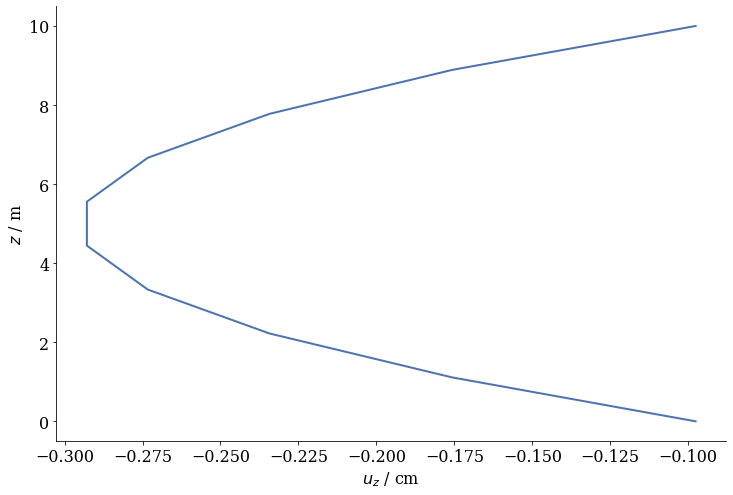

In [8]:
plt.plot(u*100,z)
plt.xlabel('$u_z$ / cm')
plt.ylabel('$z$ / m');

That doesn't look plausible. What's missing are the boundary conditions: 

$$
    u (z = 0) = 0 \qquad u'(z=H) = 0
$$

They can be integrated easily by manipulating the first and last equations (rows).

Let's start with the lower boundary condition, $u(z=0) = u_0 = 0$. Thus, we want the first equation to yield $u_0 = 0$ which can be achieved by manipulating the RHS and System matrix such that the first equation reads

$$
\begin{pmatrix}
1 & 0 & \dots & 0 
\end{pmatrix}
\begin{pmatrix}
u_0
\\
\vdots
\\
u_9
\end{pmatrix}
= 
0
$$

Nota bene: if a non-zero displacement were given as the boundary condition, the RHS entry would have to be set to that given value.

In [9]:
#lower bc
A[0,:] = 0.
A[0,0] = 1.
RHS[0] = 0.

Now we get to the upper boundary condition, $u'(z=H) = 0$. In other words, we want the slope of the $u_z - z$ curve to be zero at the upper end. Because of 

$$
        0 = u'(z=H) \approx \frac{u_9 - u_8}{\Delta z}
$$

this means that the displacements of the two final vertices should be equal. Thus, we want the final equation to yield $u_8 - u_9 = 0$ which can be achieved by manipulating the RHS and System matrix such that the first equation reads

$$
\begin{pmatrix}
0 & \dots & 0 & 1 & -1
\end{pmatrix}
\begin{pmatrix}
u_0
\\
\vdots
\\
u_7
\\
u_8
\\
u_9
\end{pmatrix}
= 
0
$$

Nota bene: if a non-zero displacement were given as the boundary condition, the RHS entry would have to be set to that given value.

In [10]:
#upper bc
A[-1,-1] = -1.
RHS[-1] = 0.

Let's check whether the manipulations were successful:

In [11]:
A

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -1.]])

In [12]:
RHS

array([0.        , 0.00019523, 0.00019523, 0.00019523, 0.00019523,
       0.00019523, 0.00019523, 0.00019523, 0.00019523, 0.        ])

Let's solve the system again with the newly implemented boundary conditions.

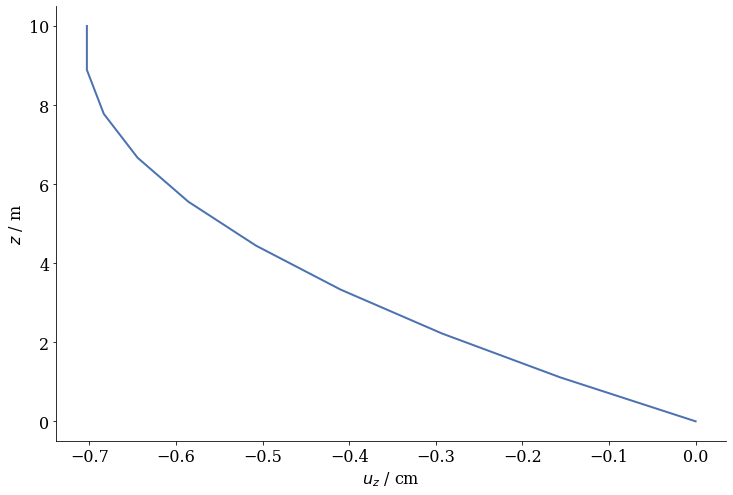

In [13]:
u = np.linalg.solve(A,RHS)
plt.plot(u*100,z)
plt.xlabel('$u_z$ / cm')
plt.ylabel('$z$ / m');

This looks plausible. Let's go ahead and perform a basic exploration of the numerical properties of the scheme.

We first define a simulation run and then vary the number of grid points.

In [14]:
def run_sim(number_of_points):
    #discretization
    Delta_z = H/(number_of_points - 1)
    z = np.linspace(0,H,number_of_points)
    #RHS
    RHS = np.ones(number_of_points) * gamma/Es * Delta_z**2
    #FD Matrix
    A = np.diag([-2.]*number_of_points,0) + np.diag([1.]*(number_of_points-1),1) + np.diag([1.]*(number_of_points-1),-1)
    #lower bc
    A[0,:] = 0.
    A[0,0] = 1.
    RHS[0] = 0
    #upper bc
    A[-1,-1] = -1.
    RHS[-1] = 0.
    #solution
    return np.linalg.solve(A,RHS), z

We plot the numerical result against the analytical solution

$$
u_z(z) = \frac{\varrho gH^2}{2E_\text{s}} \left[ \left(\frac{z}{H}\right)^2 - 2 \frac{z}{H} \right]
$$

In [15]:
# analytical solution
reference_z = np.linspace(0,H,100)
reference_solution = ((reference_z/H)**2 - 2.*reference_z/H) * gamma * H**2 / (2.*Es)

In [16]:
## Interactive playground

from ipywidgets import widgets
from ipywidgets import interact
#Compute reference solution with 100 cells

@interact(num_nodes=widgets.IntSlider(min=5, max=100, value=10, step=1, description='nodes'))
def plot(num_nodes=10):
    fig,ax = plt.subplots()
    ax.set_ylabel('$z$ / m')
    ax.set_xlabel('$u_z$ / cm')
    solution, z = run_sim(num_nodes)
    ax.plot(reference_solution*1e2, reference_z, '--', color='k', label='reference solution')
    ax.plot(solution*1e2,z,label='solution')
    ax.set_ylim([0,10])
    plt.show()

interactive(children=(IntSlider(value=10, description='nodes', min=5), Output()), _dom_classes=('widget-intera…

Convergence of this simple scheme is rather low. A comparatively simple finite element scheme converges much faster, as we shall see in one of the following exercises.

If we plot the convergence rate of the surface settlements with respect to the grid resolution, we observe a linear behaviour:

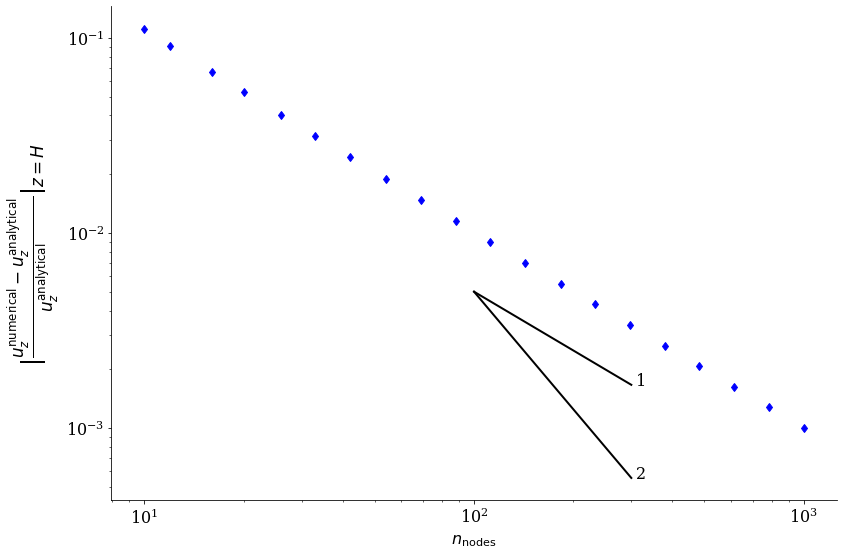

In [17]:
#HIDDEN
fig, ax = plt.subplots()
disc_n = np.logspace(1,3,20)
analytical_top = reference_solution[-1]
for nn in disc_n:
    numerical, z = run_sim(int(nn))
    numerical_top = numerical[-1]
    relerr = np.abs((numerical_top - analytical_top)/analytical_top)
    ax.plot(int(nn),relerr,ls='',marker='d',color='blue')
ax.plot([1e2,3e2],[5e-3,5e-3/3],ls='-',color='black')
ax.text(3.1e2,5e-3/3,'1')
ax.plot([1e2,3e2],[5e-3,5e-3/9],ls='-',color='black')
ax.text(3.1e2,5e-3/9,'2')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('$n_\\mathrm{nodes}$')
ax.set_ylabel('$\\left| \\frac{u_z^\\mathrm{numerical} - u_z^\\mathrm{analytical}}{u_z^\\mathrm{analytical}} \\right|_{z=H}$',size=24)
fig.tight_layout();